In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark


from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

import os
from os.path import expanduser

import pickle



import torch
# from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
ft = 14
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"


save_fig_path = expanduser("~") + '/research/data/projects/rnn_timescales/neurips_23/'

col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# Load data

In [3]:
num_neurons = 500
NET_SIZE = [num_neurons]

INPUT_SIZE = 1
NUM_CLASSES = 2
BIAS = True
NUM_READOUT_HEADS = 100
TRAIN_TAU = True


## load taus

In [15]:
def load_taus(path, curriculum_type, task, affixes, network_number, N):
    
    affix_str = '_'
    if len(affixes) > 0:
        affix_str += '_'.join(affixes) + '_'
    
    model_name = os.path.join(
        f'{curriculum_type}_{task}{affix_str}network_{network_number}')
    
    with open(path + model_name +'_N'+str(N) + '_acs_taus.pkl', 'rb') as f:
            data = pickle.load(f)
    tau_eff = data['taus_net']
    selected_models = data['selected_models']
    trained_taus = data['taus_trained']
    single_acs = data['ac_all']
    ac_pop = data['ac_pop']
    
            
#     tau_eff = np.array(tau_eff)
    return tau_eff, selected_models, trained_taus, single_acs, ac_pop 

def compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        eff_taus_all = []
        eff_taus_net_avg = np.zeros(len(net_ids))
        eff_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus(path, curriculum_type, task, affixes, net_id, N)
    #         tau_eff = tau_eff[(tau_eff>1)& (tau_eff<99)]
            tau_eff = tau_eff[(tau_eff>1)]

            eff_taus_net_avg[j] = np.mean(tau_eff)
            eff_taus_net_std[j] = np.std(tau_eff)

        tau_mean_mean[i] = np.mean(eff_taus_net_avg)
        tau_std_mean[i] = np.std(eff_taus_net_avg)
        tau_mean_std[i] = np.mean(eff_taus_net_std)
        tau_std_std[i] = np.std(eff_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std


def compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        train_taus_all = []
        train_taus_net_avg = np.zeros(len(net_ids))
        train_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus(path, curriculum_type, task, affixes, net_id, N)

            train_taus_net_avg[j] = np.mean(trained_taus)
            train_taus_net_std[j] = np.std(trained_taus)

        tau_mean_mean[i] = np.mean(train_taus_net_avg)
        tau_std_mean[i] = np.std(train_taus_net_avg)
        tau_mean_std[i] = np.mean(train_taus_net_std)
        tau_std_std[i] = np.std(train_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

# Plot

In [7]:
col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

In [10]:
def plot_shade(x, mean, std, color):
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        color=color,
        alpha=0.2,
    )

In [42]:
# loading data for panels
path_parity = expanduser("~") + '/research/data/projects/rnn_timescales/ac/ac_tau_loc_nonlin_correct/'
task = 'parity'
affixes = ['mod', 'leakyrelu']
path = path_parity

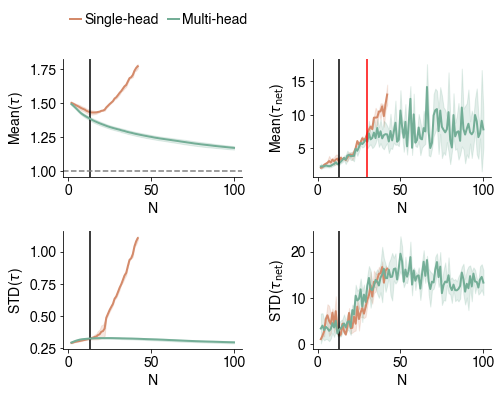

In [60]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 15*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.1
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
#c_trained = '#5A78E6'



#------------------------------------------trained tau---------------------------------------

ms = 3
lw = 2
elw = 1.5

y1 = .9
y2 = 2

ax = plt.subplot(221)
# ax.text(x_text,y_text,'c',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)

#----------------------------------------Mean tau---------------------------------------------


# Parity, single
net_ids = [0,2]
N_range = np.arange(2,43,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = col_sig_par, lw = lw, label = 'Single-head')
plot_shade(N_range, tau_mean_mean, tau_std_mean, col_sig_par)

# location where the single-head becomes increasing
loc_change = np.where(np.diff(tau_mean_mean)>0)[0][0]
plt.axvline(loc_change, color = 'k')


# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = col_multi_par, lw = lw, label = 'Multi-head')
plot_shade(N_range, tau_mean_mean, tau_std_mean, col_multi_par)

plt.axhline(1, ls = '--', color = 'gray')

plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1.1,1.5),\
           handletextpad= 0.2, handlelength = 0.8, ncol = 4, columnspacing=0.7)


ax.set_ylabel(r'Mean($\tau$)')
ax.set_xlabel(r'N')




ax = plt.subplot(222)
net_ids = np.arange(1,5)

y1 = 0.2
y2 = 1.2


# Parity, single
net_ids = [0,2]
N_range = np.arange(2,43,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = col_sig_par, lw = lw, label = 'Single-N')
plot_shade(N_range, tau_mean_mean, tau_std_mean, col_sig_par)


# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = col_multi_par, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_mean, tau_std_mean, col_multi_par)

ax.set_ylabel(r'Mean($\tau_\mathrm{net}$)')
ax.set_xlabel(r'N')
plt.axvline(loc_change, color = 'k')

plt.axvline(30, color = 'r')

# # plt.title('Multi-head', fontsize = ft)
# plt.ylim([y1, y2])
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1.1,1.5),\
#            handletextpad= 0.2, handlelength = 0.8, ncol = 4, columnspacing=0.7)

#----------------------------------------STD tau---------------------------------------------


ax = plt.subplot(223)
# ax.text(x_text,y_text,'c',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)


# Parity, single
net_ids = [0,2]
N_range = np.arange(2,43,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = col_sig_par, lw = lw, label = 'Single-N')
plot_shade(N_range, tau_mean_std, tau_std_std, col_sig_par)
plt.axvline(loc_change, color = 'k')

# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = col_multi_par, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_std, tau_std_std, col_multi_par)

# plt.axhline(1, ls = '--', color = 'gray')

ax.set_ylabel(r'STD($\tau$)')
ax.set_xlabel(r'N')


ax = plt.subplot(224)

y1 = 0.2
y2 = 1.2


# Parity, single
net_ids = [0,2]
N_range = np.arange(2,43,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = col_sig_par, lw = lw, label = 'Single-N')
plot_shade(N_range, tau_mean_std, tau_std_std, col_sig_par)
plt.axvline(loc_change, color = 'k')

# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = col_multi_par, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_std, tau_std_std, col_multi_par)

ax.set_ylabel(r'STD($\tau_\mathrm{net}$)')
ax.set_xlabel(r'N')


fig.tight_layout()

sns.despine()

In [61]:
fig.savefig(save_fig_path +'compare_taus_loc_nonlin_correct_v2.pdf')

In [56]:
net_ids = [0,2]
N_range = np.arange(2,43,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
np.where(np.diff(tau_mean_mean)>0)[0][0]

13